In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
from xhistogram.xarray import histogram
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import gridspec

In [2]:
# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4

volnorming = 10**15 #normalising coeffcients
areanorming = 10**12 #normalising coeffcients
ST_scale=bet/alph

# Establish basic constants 
yr2sec = 365.25*24*60*60
Cp=4000
rho=1024
S0=35

# If Surface fluxes are available
SF = True

if SF:
    ## ERA5 begins in 1979 so we have to change our "early" and "late" periods
    dyrs = 2014-1979+1
    init_early = 1979
    init_late = 1979
    Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12
    Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12
    range_yrs = init_late-init_early+1
else:
    dyrs = 9
    init_early = 1979
    init_late = 2006
    Early_period = (np.array([init_early,init_early+dyrs]) - init_early)*12
    Late_period = (np.array([init_late,init_late+dyrs]) - init_early)*12
    range_yrs = init_late-init_early+1

In [3]:
%%time
if SF:
    ERA5_BSP_data = xr.open_mfdataset('BSP_processed/BSP_ERA5_TS_*.nc')
    
    ## Early Period
    Part_early = ERA5_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    SA_early =  ERA5_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    CT_early = ERA5_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    V_early = ERA5_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    A_early = ERA5_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

    ## Late Period
    Part_late = ERA5_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    SA_late =  ERA5_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    CT_late = ERA5_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    V_late = ERA5_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    A_late = ERA5_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

    Basins = ERA5_BSP_data.Basin.values
else:
    EN4_BSP_data = xr.open_mfdataset('BSP_processed/BSP_EN4_TS_*.nc')

    ## Early Period
    Part_early = EN4_BSP_data.Partitions.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    SA_early =  EN4_BSP_data.S_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    CT_early = EN4_BSP_data.T_mean.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    V_early = EN4_BSP_data.V_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
    A_early = EN4_BSP_data.A_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')


    ## Late Period
    Part_late = EN4_BSP_data.Partitions.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    SA_late =  EN4_BSP_data.S_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    CT_late = EN4_BSP_data.T_mean.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    V_late = EN4_BSP_data.V_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
    A_late = EN4_BSP_data.A_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

    Basins = EN4_BSP_data.Basin.values

CPU times: user 5.32 s, sys: 424 ms, total: 5.75 s
Wall time: 11.7 s


In [4]:

# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()

# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])

Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0

In [5]:
## Load ERA5 data here, if provided
if SF:
    time = ERA5_BSP_data.Time.values
    ## Calculate the time-mean hfds and wfo
    dhfds = ERA5_BSP_data.hfds_sum.mean('Time')*(1/(24*3600)) # units: W
    dwfo = ERA5_BSP_data.wfo_sum.mean('Time') # units: kg/s

    ## Convert dflux to equivalent T or S change
    dT_hfds = dhfds/(Cp*rho*V_early)*yr2sec # units: C/yr
    dS_wfo = -dwfo*S0/(rho*V_early)*yr2sec # units: g/kg/yr

    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0

In [6]:
if SF:
    Opt_result = xr.open_mfdataset('Optimisation_results/Optimal_result_EN4_SF.nc')
    RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')
else:
    Opt_result = xr.open_mfdataset('Optimisation_results/Optimal_result_EN4.nc')
    RAPID_example = xr.open_mfdataset('~/UNSW_Work/RAPID_AMOC/moc_transports.nc')

mean_MOC_RAPID = RAPID_example.moc_mar_hc10.mean('time').values

In [7]:
# Array defining the connection between the 9 basins;
# 1 = connected (sign convention: North = +, East = +), 0 = disconnected
connectivity_array = np.zeros((Basins.size,Basins.size))

connectivity_array[0,:] = [1, -1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[1,:] = [1, 1, -1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, -1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, -1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, -1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, -1]
connectivity_array[6,:] = [0, 0, 0, 0, -1, -1, 1, 1, 0]
connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, -1, 1, 0]
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

g_ij = Opt_result.gij.values

section_trans = np.ones((Vol_1.size,Vol_1.size))*0
for i in (range(Vol_1.size)):
    for j in range(Vol_2.size):
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]!=0:
            if Basin_names[i] != Basin_names[j]:
                section_trans[i,j] = g_ij[i,j]*connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]/(yr2sec*10**6)

int_section_trans = np.zeros((Basins.size, Basins.size))
for i in (range(Basins.size)):
    for j in range(Basins.size):
        int_section_trans[i,j] = np.nansum(section_trans[128*i:(128*(i+1)),128*j:(128*(j+1))])

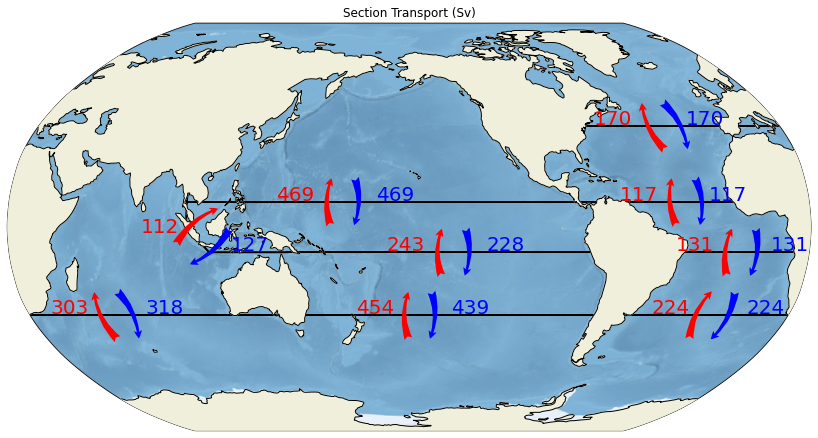

In [8]:
mask_EN4_xr = xr.open_mfdataset('mask_EN4.nc')
mask_full = 0
for i in range(Basins.size):
    tmp = (mask_EN4_xr.where(mask_EN4_xr.__xarray_dataarray_variable__.isel(Basins=i)>=0).isel(depth=1,Basins=i)*i)
    mask_full = mask_full+ tmp

fig  = plt.figure(1, figsize = (17.5, 7.5))
gs = gridspec.GridSpec(1,1)
gs.update(wspace = 0.4, hspace=0)

ax1 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=-160))
minv, maxv = 0,8

ax1.stock_img()
ax1.coastlines(zorder=101)

## SECTIONS
# Pacific Sector
ax1.plot([145,300],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,300],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([100,280],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Indian Sector
ax1.plot([25,145],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([145,110,100,100],[-10,-10,0,20], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

# Atlantic Sector
ax1.plot([300,360],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-35,-35], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([300,360],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[-10,-10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[10,10], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([280,360],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')
ax1.plot([0,25],[40,40], transform = ccrs.PlateCarree(), linewidth = 2, color='black')

ax1.add_feature(cfeature.LAND, zorder=100)

## S PAC <> SO

ax1.annotate('', xy=(200,-25), xytext=(200, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[5,-1])), xy=(200,-25), xytext=(220, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(210,-45), xytext=(210, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,5]), xy=(175,-25), xytext=(175, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> S PAC

ax1.annotate('', xy=(215,0), xytext=(215, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,5])), xy=(235,-9.5), xytext=(235, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(225,-20), xytext=(225, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[5,6]), xy=(190,-9.5), xytext=(190, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> N PAC

ax1.annotate('', xy=(165,20), xytext=(165, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[7,6])), xy=(185,10.5), xytext=(185, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(175,0), xytext=(175, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,7])), xy=(140,10.5), xytext=(140, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## IND <> SO

ax1.annotate('', xy=(55,-25), xytext=(55, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(int_section_trans[4,-1])), xy=(75,-25), xytext=(75, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(65,-45), xytext=(65, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,4]), xy=(30,-25), xytext=(30, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ PAC <> IND

ax1.annotate('', xy=(115, 7.5), xytext=(95,-7.5),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[6,4])), xy=(75,-9.5), xytext=(120, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(100, -15), xytext=(120,0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[4,6]), xy=(80,-2.5), xytext=(80, -2.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)


## S ATL <> SO

ax1.annotate('', xy=(340,-25), xytext=(340, -45),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[3,-1])), xy=(360,-25), xytext=(360, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(350,-45), xytext=(350, -25),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[-1,3]), xy=(315,-25), xytext=(315, -34.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ ATL <> S ATL

ax1.annotate('', xy=(345,0), xytext=(345, -20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[2,3])), xy=(2.5,-9.5), xytext=(2.5, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(355,-20), xytext=(355, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(int(int_section_trans[3,2]), xy=(320,-9.5), xytext=(320, -9.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## EQ ATL <> ST ATL

ax1.annotate('', xy=(320,20), xytext=(320, 0),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[1,2])), xy=(335,10.5), xytext=(335, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(330,0), xytext=(330, 20),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[2,1])), xy=(295,10.5), xytext=(295, 10.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

## ST ATL <> POL ATL

ax1.annotate('', xy=(320,50), xytext=(320, 30),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='red', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)
ax1.annotate(abs(int(int_section_trans[0,1])), xy=(335,40.5), xytext=(335, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='blue', fontsize=20, zorder=103)

ax1.annotate('', xy=(330,30), xytext=(330, 50),
        size=20, xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),\
        arrowprops=dict(facecolor='blue', ec='none',
                        arrowstyle="fancy",connectionstyle="arc3,rad=-0.2"), zorder=102)

ax1.annotate(abs(int(int_section_trans[1,0])), xy=(290,40.5), xytext=(290, 40.5), \
        xycoords = ccrs.PlateCarree()._as_mpl_transform(ax1),  color='red', fontsize=20, zorder=103)

plt.title('Section Transport (Sv)')
if SF:
    plt.savefig('Figures/Land_mask_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/Land_mask_freerun.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
section_names = np.array([r'40$^{\circ}$N (Atlantic)', 
                r'10$^{\circ}$N (Atlantic)',
                r'10$^{\circ}$S (Atlantic)', 
                r'35$^{\circ}$S (Atlantic)',
                r'35$^{\circ}$S (Indian)',
                r'110 - 100 $^{\circ}$E, 10 - 0 $^{\circ}$S (ITF)',
                r'35$^{\circ}$S (Pacific)',
                r'10$^{\circ}$S (Pacific)',
                r'10$^{\circ}$N (Pacific)'])

section_trans_basin = np.zeros((Basins.size, Vol_1.size))
for i in (range(Basins.size)):
    section_trans_basin[i,:] = (np.nansum(section_trans[128*i:(128*(i+1)),:], axis=0))

southern_trans = np.zeros((Basins.size, SA_early.shape[1]))

tmp_0 = 0
tmp_1 = 0
tmp_2 = 0
tmp_3 = 0
tmp_4 = 0
tmp_5 = 0
tmp_6 = 0
tmp_7 = 0
tmp_8 = 0
for i in range(Basins.size):
    for j in range(Basins.size):
        ## Atlantic
        if (i == 0 and j ==1 ) or (j == 0 and i == 1):
            tmp_0 = tmp_0 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[0,:] = tmp_0
        if (i == 1 and j == 2) or (j == 1 and i== 2):
            tmp_1 = tmp_1 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[1,:] = tmp_1
        if (i == 2 and j == 3) or (j == 2 and i== 3):
            tmp_2 = tmp_2 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[2,:] = tmp_2
        if (i == 3 and j == 8) or (j == 3 and i == 8):
            tmp_3 = tmp_3 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[3,:] = tmp_3
        ## Indian
        if (i == 4 and j == 8) or (j == 4 and i == 8):
            tmp_4 = tmp_4 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[4,:] = tmp_4
        if (i == 4 and j == 6) or (j == 4 and i == 6):
            tmp_5 = tmp_5 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[5,:] = tmp_5
        ## Pacific
        if (i == 5 and j == 8) or (j == 5 and i == 8):
            tmp_6 = tmp_6 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[6,:] = tmp_6
        if (i == 6 and j == 5) or (j == 6 and i == 5):
            tmp_7 = tmp_7 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[7,:] = tmp_7
        if (i == 7 and j == 6) or (j == 7 and i == 6):
            tmp_8 = tmp_8 + section_trans_basin[i,128*j:(128*(j+1))]
            southern_trans[8,:] = tmp_8

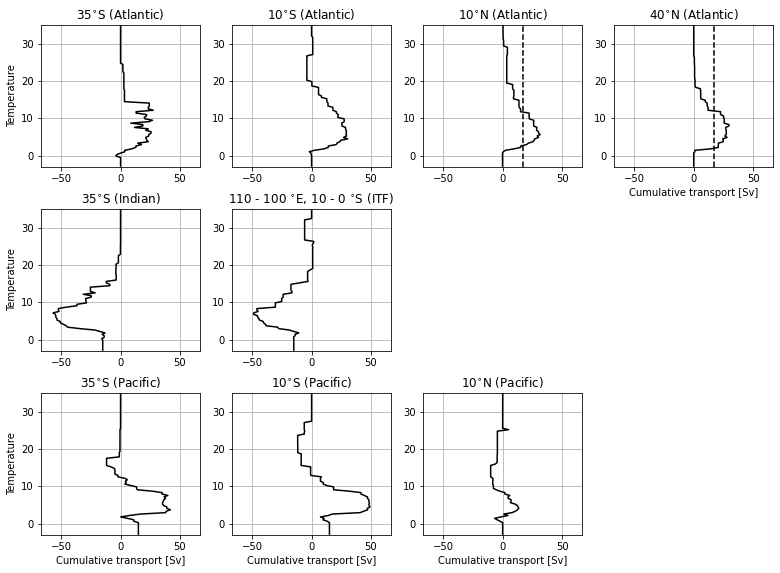

In [10]:
from scipy import stats

temp_bins = np.linspace(-3,35,100)
temp_mid = 0.5*(temp_bins[1:]+temp_bins[:-1])

temp_binned_transport = np.zeros((Basins.size, temp_mid.size))
temp_binned_transport[0,:] = stats.binned_statistic((T_1.reshape(9,128)[0,:]+T_1.reshape(9,128)[1,:])/2, southern_trans[0,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[1,:] = stats.binned_statistic((T_1.reshape(9,128)[1,:]+T_1.reshape(9,128)[2,:])/2, southern_trans[1,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[2,:] = stats.binned_statistic((T_1.reshape(9,128)[2,:]+T_1.reshape(9,128)[3,:])/2, southern_trans[2,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[3,:] = stats.binned_statistic((T_1.reshape(9,128)[3,:]+T_1.reshape(9,128)[8,:])/2, southern_trans[3,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[4,:] = stats.binned_statistic((T_1.reshape(9,128)[4,:]+T_1.reshape(9,128)[8,:])/2, southern_trans[4,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[5,:] = stats.binned_statistic((T_1.reshape(9,128)[4,:]+T_1.reshape(9,128)[6,:])/2, southern_trans[5,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[6,:] = stats.binned_statistic((T_1.reshape(9,128)[5,:]+T_1.reshape(9,128)[8,:])/2, southern_trans[6,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[7,:] = stats.binned_statistic((T_1.reshape(9,128)[6,:]+T_1.reshape(9,128)[5,:])/2, southern_trans[7,:], bins = np.linspace(-3,35,100), statistic='sum').statistic
temp_binned_transport[8,:] = stats.binned_statistic((T_1.reshape(9,128)[7,:]+T_1.reshape(9,128)[6,:])/2, southern_trans[8,:], bins = np.linspace(-3,35,100), statistic='sum').statistic

fig  = plt.figure(1, figsize = (17.5*0.75, 12.5*0.75))
gs = gridspec.GridSpec(3,4)
gs.update(wspace = 0.2, hspace=0.3)

ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0]), \
           plt.subplot(gs[0,1]), \
           plt.subplot(gs[0,2]) , \
           plt.subplot(gs[0,3])

ax5, ax6 = plt.subplot(gs[1,0]), \
           plt.subplot(gs[1,1])

ax7, ax8,ax9 = plt.subplot(gs[2,0]), \
           plt.subplot(gs[2,1]), \
            plt.subplot(gs[2,2])

ax1.plot(np.cumsum((temp_binned_transport[3,:])[::-1])[::-1],temp_mid, '-k')
ax1.set_title(section_names[3])
ax1.set_ylim(-3,35)
ax1.set_xlim(-67,67)

ax2.plot(np.cumsum((temp_binned_transport[2,:])[::-1])[::-1],temp_mid, '-k')
ax2.set_title(section_names[2])
ax2.set_ylim(-3,35)
ax2.set_xlim(-67,67)

ax3.plot(np.cumsum((temp_binned_transport[1,:])[::-1])[::-1],temp_mid, '-k')
ax3.vlines(mean_MOC_RAPID, -3,35, color='black', linestyle='dashed')
ax3.set_title(section_names[1])
ax3.set_ylim(-3,35)
ax3.set_xlim(-67,67)

ax4.plot(np.cumsum((temp_binned_transport[0,:])[::-1])[::-1],temp_mid, '-k')
ax4.vlines(mean_MOC_RAPID, -3,35, color='black', linestyle='dashed')
ax4.set_title(section_names[0])
ax4.set_ylim(-3,35)
ax4.set_xlim(-67,67)
ax4.set_xlabel('Cumulative transport [Sv]')

ax5.plot(np.cumsum((temp_binned_transport[4,:])[::-1])[::-1],temp_mid, '-k')
ax5.set_title(section_names[4])
ax5.set_ylim(-3,35)
ax5.set_xlim(-67,67)

ax6.plot(np.cumsum((temp_binned_transport[5,:])[::-1])[::-1],temp_mid, '-k')
ax6.set_title(section_names[5])
ax6.set_ylim(-3,35)
ax6.set_xlim(-67,67)

ax7.plot(np.cumsum((temp_binned_transport[6,:])[::-1])[::-1],temp_mid, '-k')
ax7.set_title(section_names[6])
ax7.set_ylim(-3,35)
ax7.set_xlim(-67,67)
ax7.set_xlabel('Cumulative transport [Sv]')

ax8.plot(np.cumsum((temp_binned_transport[7,:])[::-1])[::-1],temp_mid, '-k')
ax8.set_title(section_names[7])
ax8.set_ylim(-3,35)
ax8.set_xlim(-67,67)
ax8.set_xlabel('Cumulative transport [Sv]')

ax9.plot(np.cumsum((temp_binned_transport[8,:])[::-1])[::-1],temp_mid, '-k')
ax9.set_title(section_names[8])
ax9.set_ylim(-3,35)
ax9.set_xlim(-67,67)
ax9.set_xlabel('Cumulative transport [Sv]')

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()
ax7.grid()
ax8.grid()
ax9.grid()

ax1.set_ylabel('Temperature')
ax5.set_ylabel('Temperature')
ax7.set_ylabel('Temperature')

if SF:
    plt.savefig('Figures/Section_transports_Temp_space_knownSF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/Section_transports_Temp_space_freerun.png', bbox_inches='tight', dpi=300)

plt.show()

-------------

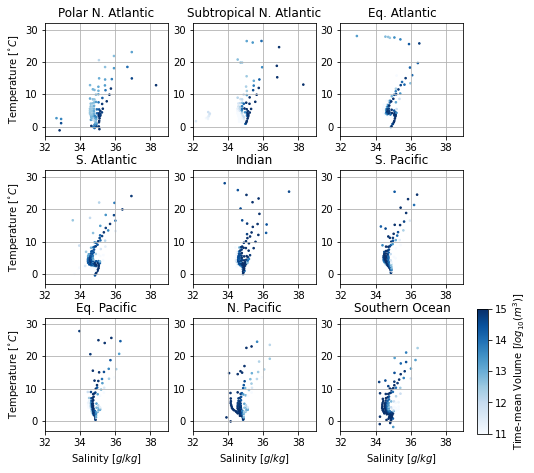

In [111]:
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = 11,15
cmap = 'Blues'

for bx in range(Basins.size):
    axs[bx].scatter(SA_early[bx,:],CT_early[bx,:], 10, np.log10(V_early[bx,:]),cmap=cmap, vmin=minv, vmax=maxv, marker = '.')
    axs[bx].set_xlim(32,39)
    axs[bx].set_ylim(-3,32)
    axs[bx].set_title(Basins[bx])
    if bx==0 or bx==3 or bx==6:
        axs[bx].set_ylabel('Temperature [$^{\circ}C$]')
    if bx==6 or bx==7 or bx==8:
        axs[bx].set_xlabel('Salinity [$g/kg$]')
    axs[bx].grid()
    
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Time-mean Volume [$log_{10}(m^3)$]') 
if SF:
    plt.savefig('Figures/BSP_clustering_mean_volumes_Vbased_SF.png', bbox_inches='tight', dpi=300)
else:
    plt.savefig('Figures/BSP_clustering_mean_volumes_Vbased.png', bbox_inches='tight', dpi=300)
plt.show()

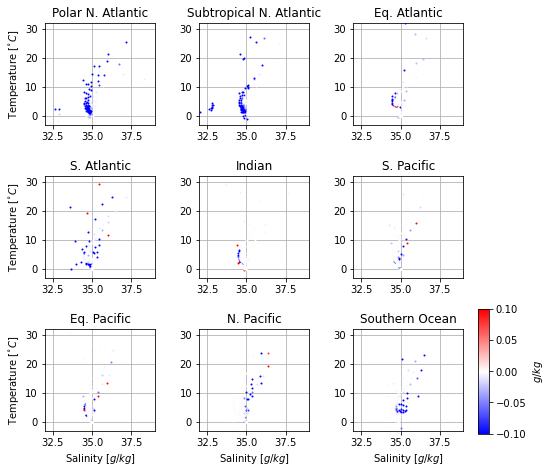

CPU times: user 15.1 s, sys: 710 ms, total: 15.8 s
Wall time: 15.7 s


In [112]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dS_adjustment[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
plt.show()

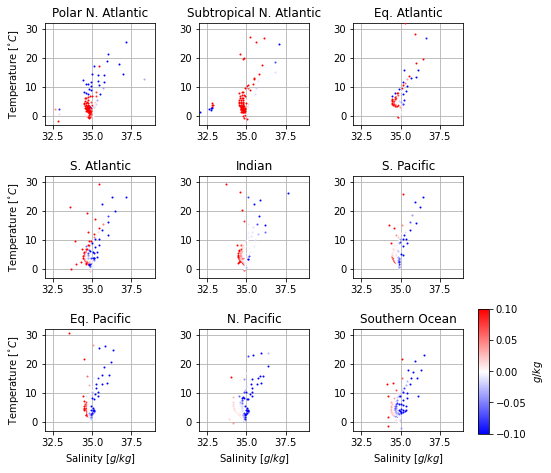

CPU times: user 14.4 s, sys: 704 ms, total: 15.1 s
Wall time: 15 s


In [113]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dS_mixing[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
plt.show()

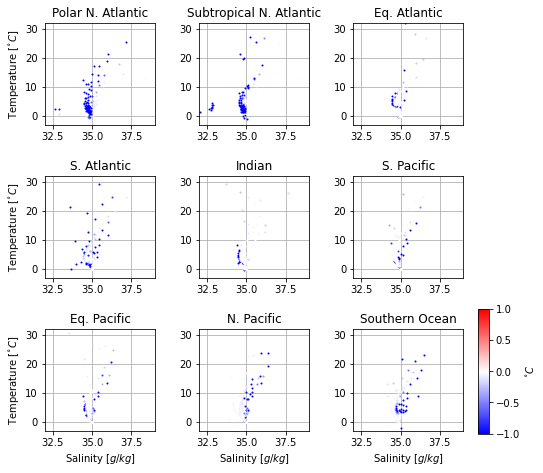

CPU times: user 14.7 s, sys: 722 ms, total: 15.4 s
Wall time: 15.2 s


In [114]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -1,1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dT_adjustment[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
plt.show()

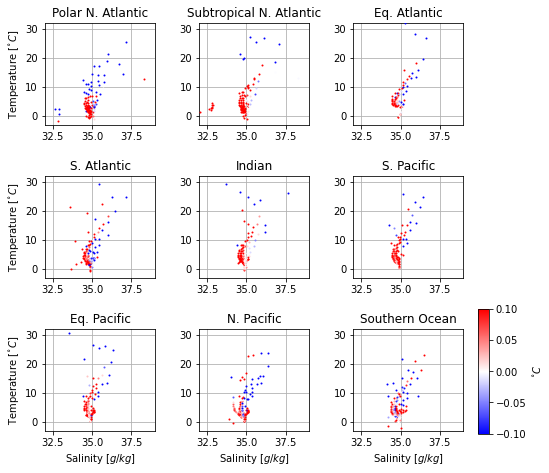

CPU times: user 15.4 s, sys: 689 ms, total: 16.1 s
Wall time: 16.2 s


In [115]:
%%time
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 
cax = fig.add_axes([0.927, 0.12, 0.02, 0.23])

minv, maxv = -.1,.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]), 1, color=cmap(norm(Opt_result.dT_mixing[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
plt.show()

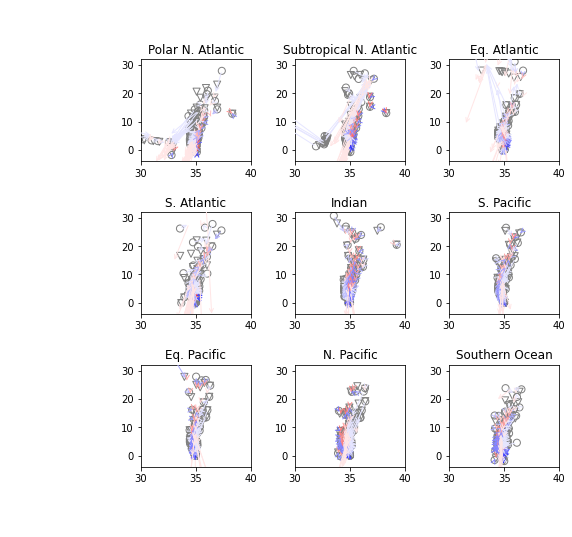

In [12]:
fig, axs = plt.subplots(3,3, figsize=(7.5,7.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=0.4)
axs = axs.ravel() 

k=0
for i in range(np.array(Basins).size):
    for j in range(SA_early.shape[1]):
        col = 1-np.maximum(0.1,(np.log10(Vol_1[k]+1)-14)/(np.log10(np.max(Vol_1))-14))
        axs[i].scatter(S_1[k]+S0,T_1[k],\
                s=50,\
                marker = 'o', facecolor='none', edgecolor='grey', label = 't2', zorder=-100)
        axs[i].scatter(S_2[k]+S0,T_2[k],\
                s=50,\
                marker = 'v', facecolor='none', edgecolor='grey', label = 't1', zorder=-100)
        if ~np.isnan(Opt_result.dT_mixing[k]) | ~np.isnan(Opt_result.dS_mixing[k]):
                ann1 = axs[i].annotate('', xy=(S_1[k]+S0, T_1[k]), xytext=(S_1[k]+Opt_result.dS_mixing[k]+S0, T_1[k]+Opt_result.dT_mixing[k]),
    arrowprops=dict(arrowstyle="<-", color=[col,col,1]), annotation_clip=False)
                ann2 = axs[i].annotate('', xy=(S_1[k]+Opt_result.dS_mixing[k]+S0, T_1[k]+Opt_result.dT_mixing[k]), \
                    xytext=(S_1[k]+Opt_result.dS_mixing[k]+S0+Opt_result.dS_adjustment[k], \
                            T_1[k]+Opt_result.dT_mixing[k]+Opt_result.dT_adjustment[k]),
    arrowprops=dict(arrowstyle="<-", color=[1,col,col]), annotation_clip=False)
        else:
                ann1 = axs[i].annotate('', xy=(S_1[k]+S0, T_1[k]), \
                    xytext=(S_1[k]+S0+Opt_result.dS_adjustment[k], T_1[k]+Opt_result.dT_adjustment[k]),
    arrowprops=dict(arrowstyle="<-", color='red'), annotation_clip=False)
        axs[i].set_xlim(30,40)
        axs[i].set_ylim(-4,32)
        axs[i].set_title(Basins[i])
        ann1.arrow_patch.set_clip_box(axs[i].bbox)
        ann2.arrow_patch.set_clip_box(axs[i].bbox)
        k=k+1

m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')

plt.show()

______


In [120]:
## Run below code when MTM is modified, otherwise comment it
## Takes approx 8 mins to run

In [18]:
run MTM_remapping_EN4.ipynb

  0%|          | 0/128 [00:00<?, ?it/s]

In [19]:
## LOAD T and S data from a gridded observations (e.g., we use EN4 here)
## For the purposes of the tutorial we only select the first 3 months of the data
data = xr.open_mfdataset('~/UNSW_work/EN4_Data/EN_data/EN4_CT_SA_*')

SST = data.Cons_Temp.isel(time=slice(Early_period[0],Early_period[1])).mean('time', keepdims=True).isel(depth=0)
land_mask = (SST/SST).load()
V = data.dVol.isel(time=slice(Early_period[0],Early_period[1])).mean('time').load()
darea = (data.dArea.isel(time=slice(Early_period[0],Early_period[1])).mean('time')*land_mask).load()

In [20]:
if SF:
    data_ERA5 = xr.open_mfdataset('~/UNSW_Work/ERA5/*') ## hfds: J; wfo: kgs^-1
    ## TIME-MEAN FLUXES
    hfds_ERA5 = data_ERA5.hfds.mean('time')/darea*(1/(24*3600)) # UNITS: [W/m2]
    wfo_ERA5 = (data_ERA5.wfo.mean('time')*(24*3600)/(darea*rho)*1000) # UNITS: [mm/day]


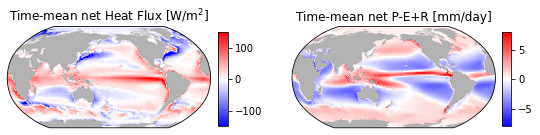

In [21]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(1,2)
    gs.update(wspace = 0.4, hspace=0)


    ax1, ax2 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180))

    minv, maxv = -150,150

    hfds_ERA5.plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)

    cax = fig.add_axes([0.46, 0.32, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')


    minv, maxv = -8,8
    wfo_ERA5.plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Time-mean net Heat Flux [W/m$^2$]')
    ax2.set_title('Time-mean net P-E+R [mm/day]')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.91, 0.32, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 

    plt.savefig('Figures/net_hfds_wfo_ERA5.png', bbox_inches='tight', dpi=300)

In [22]:
if SF:
    dT_mix = xr.open_mfdataset('dT_mix_Eulerian_SF.nc').__xarray_dataarray_variable__.values
    dS_mix = xr.open_mfdataset('dS_mix_Eulerian_SF.nc').__xarray_dataarray_variable__.values
    dT_adj = xr.open_mfdataset('dT_adj_Eulerian_SF.nc').__xarray_dataarray_variable__.values
    dS_adj = xr.open_mfdataset('dS_adj_Eulerian_SF.nc').__xarray_dataarray_variable__.values
    g_ij_3D = xr.open_mfdataset('g_ij_Eulerian_SF.nc').__xarray_dataarray_variable__.values

    ## Convert dflux to equivalent T or S change
    hfds_mix = dT_mix*(Cp*rho*V) # units: W
    wfo_mix = -dS_mix/S0*(rho*V) # units: kg/s
    hfds_adj = dT_adj*(Cp*rho*V) # units: W
    wfo_adj = -dS_adj/S0*(rho*V) # units: kg/s

else:
    dT_mix = xr.open_mfdataset('dT_mix_Eulerian.nc').__xarray_dataarray_variable__.values
    dS_mix = xr.open_mfdataset('dS_mix_Eulerian.nc').__xarray_dataarray_variable__.values
    dT_adj = xr.open_mfdataset('dT_adj_Eulerian.nc').__xarray_dataarray_variable__.values
    dS_adj = xr.open_mfdataset('dS_adj_Eulerian.nc').__xarray_dataarray_variable__.values
    g_ij_3D = xr.open_mfdataset('g_ij_Eulerian.nc').__xarray_dataarray_variable__.values


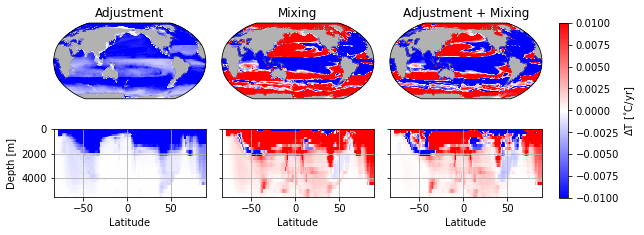

In [23]:

fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,9, height_ratios = [2,1])
gs.update(wspace = 0.4, hspace=0)


ax1, ax2, ax3 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,6:], projection=ccrs.Robinson(central_longitude=180)) \

ax4, ax5, ax6 = plt.subplot(gs[1,:3]), \
           plt.subplot(gs[1,3:6]), \
           plt.subplot(gs[1,6:]) 
if SF:
    minv, maxv = -0.01,0.01
    ((dT_mix*V).sum('depth')/V.sum('depth')*SST/SST).plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax2.set_title('Mixing')
    ((dT_adj*V).sum('depth')/V.sum('depth')*SST/SST).plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Adjustment')
    (((dT_adj+dT_mix)*V).sum('depth')/V.sum('depth')*SST/SST).plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax3.set_title('Adjustment + Mixing')

    ((dT_mix*V).sum('lon')/V.sum('lon')).plot(ax = ax5, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
    ((dT_adj*V).sum('lon')/V.sum('lon')).plot(ax = ax4, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
    (((dT_adj+dT_mix)*V).sum('lon')/V.sum('lon')).plot(ax = ax6, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)

else:
    minv, maxv = -0.01,0.01

    ((dT_mix*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax2.set_title('Mixing')
    ((dT_adj*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Adjustment')
    (((dT_adj+dT_mix)*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax3.set_title('Adjustment + Mixing')

    ((dT_mix*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax5, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
    ((dT_adj*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax4, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
    (((dT_adj+dT_mix)*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax6, \
        vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

ax4.invert_yaxis()
ax5.invert_yaxis()
ax6.invert_yaxis()

ax4.set_ylabel('Depth [m]')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax5.set_yticklabels([])
ax6.set_yticklabels([])

ax4.set_xlabel('Latitude')
ax5.set_xlabel('Latitude')
ax6.set_xlabel('Latitude')

ax4.grid()
ax5.grid()
ax6.grid()

cax = fig.add_axes([0.927, 0.12, 0.015, 0.65])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$\Delta$T [$^{\circ}$C/yr]')
if SF:
    plt.savefig('Figures/latlon_remapping_knownSF_dT_79_14.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('Figures/latlon_remapping_freerun_dT_79_06.png', dpi=300, bbox_inches='tight')
plt.show()


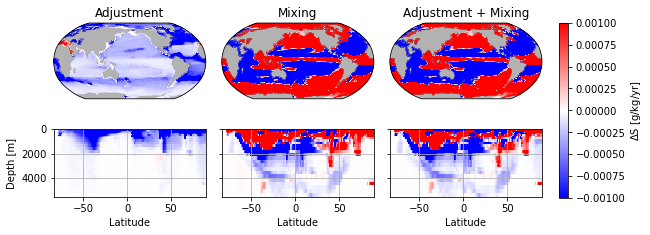

In [24]:
fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,9, height_ratios = [2,1])
gs.update(wspace = 0.4, hspace=0)

minv, maxv = -0.001,0.001

ax1, ax2, ax3 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,6:], projection=ccrs.Robinson(central_longitude=180)) \

ax4, ax5, ax6 = plt.subplot(gs[1,:3]), \
           plt.subplot(gs[1,3:6]), \
           plt.subplot(gs[1,6:]) \

((dS_mix*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
    ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax2.set_title('Mixing')
((dS_adj*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
    ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax1.set_title('Adjustment')
(((dS_adj+dS_mix)*V).sum('depth')/V.sum('depth')*SST/SST*(1/range_yrs)).plot(\
    ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax3.set_title('Adjustment + Mixing')

((dS_mix*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax5, \
    vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
((dS_adj*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax4, \
    vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)
(((dS_adj+dS_mix)*V).sum('lon')/V.sum('lon')*(1/range_yrs)).plot(ax = ax6, \
    vmin=minv, vmax=maxv, cmap=plt.cm.bwr, add_colorbar=False)

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

ax4.invert_yaxis()
ax5.invert_yaxis()
ax6.invert_yaxis()

ax4.set_ylabel('Depth [m]')
ax5.set_ylabel('')
ax6.set_ylabel('')
ax5.set_yticklabels([])
ax6.set_yticklabels([])

ax4.set_xlabel('Latitude')
ax5.set_xlabel('Latitude')
ax6.set_xlabel('Latitude')

ax4.grid()
ax5.grid()
ax6.grid()

cax = fig.add_axes([0.927, 0.12, 0.015, 0.65])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$\Delta$S [g/kg/yr]')

if SF:
    plt.savefig('Figures/latlon_remapping_knownSF_dS_79_14.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('Figures/latlon_remapping_freerun_dS_79_06.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
CT_eul_early = data.Cons_Temp.isel(time=slice(Early_period[0],Early_period[1])).mean('time')
CT_eul_late = data.Cons_Temp.isel(time=slice(Late_period[0],Late_period[1])).mean('time')

SA_eul_early = data.Abs_Sal.isel(time=slice(Early_period[0],Early_period[1])).mean('time')
SA_eul_late = data.Abs_Sal.isel(time=slice(Late_period[0],Late_period[1])).mean('time')

# Compute Eulerian change in temperature (just a simple difference)
dT_eul=CT_eul_late-CT_eul_early
if SF: 
    # Compute depth integrated heat content (units: W/m^2)
    dH_mix = Cp*rho*(dT_mix*V).sum('depth')/(darea*yr2sec)
    dH_eul = Cp*rho*(dT_eul*V).sum('depth')/(darea*yr2sec)
    dH_adj = Cp*rho*(dT_adj*V).sum('depth')/(darea*yr2sec)
else:
    # Compute depth integrated heat content (units: W/m^2)
    dH_mix = Cp*rho*(dT_mix*V).sum('depth')/(darea*range_yrs*yr2sec)
    dH_eul = Cp*rho*(dT_eul*V).sum('depth')/(darea*range_yrs*yr2sec)
    dH_adj = Cp*rho*(dT_adj*V).sum('depth')/(darea*range_yrs*yr2sec)

dH_redist = dH_eul-dH_adj

# # Compare Mixing, Redistribution and Adjustment fresh water change
# # Compute Eulerian change in temperature (just a simple difference)
dS_eul=SA_eul_late-SA_eul_early
if SF: 
    # Compute implied fresh water content change (units: mm/yr)
    dW_mix = (-1/S0)*(dS_mix*V).sum('depth')/(darea)*1000
    dW_eul = (-1/S0)*(dS_eul*V).sum('depth')/(darea)*1000
    dW_adj = (-1/S0)*(dS_adj*V).sum('depth')/(darea)*1000
else:
    # Compute implied fresh water content change (units: mm/yr)
    dW_mix = (-1/S0)*(dS_mix*V).sum('depth')/(darea*range_yrs)*1000
    dW_eul = (-1/S0)*(dS_eul*V).sum('depth')/(darea*range_yrs)*1000
    dW_adj = (-1/S0)*(dS_adj*V).sum('depth')/(darea*range_yrs)*1000

dW_redist = dW_eul - dW_adj

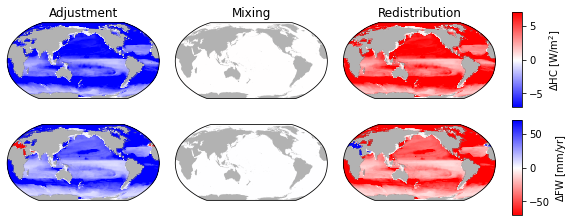

In [26]:
fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
gs = gridspec.GridSpec(2,9, height_ratios = [1,1])
gs.update(wspace = 0.4, hspace=0)

minv, maxv = -7,7

ax1, ax2, ax3 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[0,6:], projection=ccrs.Robinson(central_longitude=180)) \

ax4, ax5, ax6 = plt.subplot(gs[1,:3], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[1,3:6], projection=ccrs.Robinson(central_longitude=180)), \
           plt.subplot(gs[1,6:], projection=ccrs.Robinson(central_longitude=180)) \

dH_adj.plot(\
    ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
dH_eul.plot(\
    ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax1.set_title('Adjustment')
ax2.set_title('Mixing')
dH_redist.plot(\
    ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax3.set_title('Redistribution')

minv, maxv = -70,70

dW_adj.plot(\
    ax = ax4, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
dW_eul.plot(\
    ax = ax5, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
dW_redist.plot(\
    ax = ax6, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
         add_colorbar=False)
ax4.set_title('')
ax5.set_title('')
ax6.set_title('')

ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
ax6.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

cax = fig.add_axes([0.927, 0.12, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr_r')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$\Delta$FW [mm/yr]')

minv, maxv = -7,7

cax = fig.add_axes([0.927, 0.52, 0.015, 0.35])
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
cbar.set_label('$\Delta$HC [W/m$^2$]')

if SF:
    plt.savefig('Figures/latlon_remapping_knownSF_OHC_FW_79_14.png', dpi=300, bbox_inches='tight')
else:
    plt.savefig('Figures/latlon_remapping_freerun_OHC_FW_79_06.png', dpi=300, bbox_inches='tight')

plt.show()

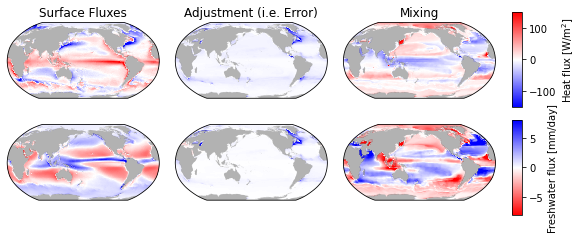

In [27]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,9, height_ratios = [1,1])
    gs.update(wspace = 0.4, hspace=0)

    minv, maxv = -150,150

    ax1, ax2, ax3 = plt.subplot(gs[0,:3], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,3:6], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,6:], projection=ccrs.Robinson(central_longitude=180)) \

    ax4, ax5, ax6 = plt.subplot(gs[1,:3], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[1,3:6], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[1,6:], projection=ccrs.Robinson(central_longitude=180)) \

    dH_adj.plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    hfds_ERA5.plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Surface Fluxes')
    ax2.set_title('Adjustment (i.e. Error)')
    dH_mix.plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax3.set_title('Mixing')

    minv, maxv = -8,8

    (dW_adj/365.25).plot(\
        ax = ax5, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    (wfo_ERA5).plot(\
        ax = ax4, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    (dW_mix/365.25).plot(\
        ax = ax6, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax4.set_title('')
    ax5.set_title('')
    ax6.set_title('')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax5.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax6.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.927, 0.12, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr_r')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Freshwater flux [mm/day]')

    minv, maxv = -150,150

    cax = fig.add_axes([0.927, 0.52, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('Heat flux [W/m$^2$]')

    plt.savefig('Figures/latlon_remapping_knownSF_comp.png', dpi=300, bbox_inches='tight')

    plt.show()

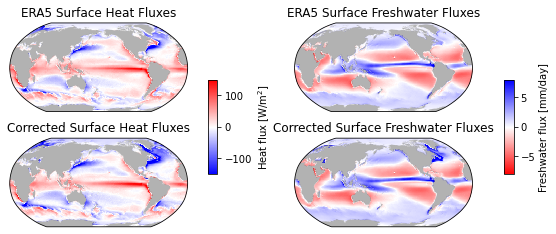

In [28]:
if SF:
    fig  = plt.figure(1, figsize = (17.5*0.5, 7.5*0.5))
    gs = gridspec.GridSpec(2,2)
    gs.update(wspace = 0.4, hspace=0.3)

    minv, maxv = -150,150

    ax2, ax3 = plt.subplot(gs[0,0], projection=ccrs.Robinson(central_longitude=180)), \
            plt.subplot(gs[0,1], projection=ccrs.Robinson(central_longitude=180))


    ax1, ax4 = plt.subplot(gs[1,0], projection=ccrs.Robinson(central_longitude=180)), \
                plt.subplot(gs[1,1], projection=ccrs.Robinson(central_longitude=180))

    (dH_adj+hfds_ERA5).plot(\
        ax = ax1, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax1.set_title('Corrected Surface Heat Fluxes')

    (hfds_ERA5).plot(\
        ax = ax2, vmin=minv, vmax=maxv, cmap=plt.cm.bwr,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax2.set_title('ERA5 Surface Heat Fluxes')

    minv, maxv = -8,8

    (dW_adj/365.25+wfo_ERA5).plot(\
        ax = ax4, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax4.set_title('Corrected Surface Freshwater Fluxes')

    (wfo_ERA5).plot(\
        ax = ax3, vmin=minv, vmax=maxv, cmap=plt.cm.bwr_r,  transform = ccrs.PlateCarree(), \
            add_colorbar=False)
    ax3.set_title('ERA5 Surface Freshwater Fluxes')

    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax2.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))
    ax4.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor='grey', alpha=0.6))

    cax = fig.add_axes([0.93, 0.32, 0.015, 0.35])
    m = plt.cm.ScalarMappable(cmap='bwr_r')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('Freshwater flux [mm/day]')

    minv, maxv = -150,150

    cax = fig.add_axes([0.46, 0.32, 0.015, 0.35])

    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical') 
    cbar.set_label('Heat flux [W/m$^2$]')

    plt.savefig('Figures/Corrected_fluxes_knownSF_comp.png', dpi=300, bbox_inches='tight')

    plt.show()